# WSI 24L
## Ćwiczenie 6 - uczenie ze wzmocnieniem
### Igor Szabłowski

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns

### Implementacja
Zaimplementowany został algorytm Q-Learning. Został on zaimplementowany w formie funkcji przyjmującej parametry dotyczące uczenia takie jak: beta - learning rate, gamma - discount factor, eps - prawdopodobieństwo na wybranie losowej akcji, tmax - ilość akcji do wykonania w jednej rozgrywce, episodes_count - ilość gier przez które ma być tworzona macierz Q, oraz te związane z samym środowiskiem rozgrywki: Q - macierz o rozmiarach ilości stanów x ilość możliwych akcji, reset_game - funkcja resetująca środowisko gry do stanu początkowego, make_action - funkcja wykonująca ruch w środowisku. Wartościami zwracanymi przez funkcje są nauczona macierz Q, lista zawierająca sume nagród zdobytych w każdej rozgrywce oraz lista zawierająca ilość kroków w których udało się ukończych każdą z rozgrywek. Zwracane listy służą do późniejszej analizy wykonanych prób.

In [2]:
def qlearning(tmax, gamma, beta, Q, eps, reset_game, make_action, episodes_count):
    rewards_list = []
    steps_list = []
    for _ in range(episodes_count):
        state = reset_game()[0]
        game_reward = 0
        for i in range(tmax):
            if np.random.random() < eps:
                action = np.random.choice(Q.shape[1])
            else:
                try:
                    action = np.random.choice(np.where(Q[state] == np.max(Q[state]))[0])
                except:
                    action = np.argmax(Q[state])

            next_state, reward, is_done, _, _ = make_action(action)

            Q[state, action] += beta*(reward + gamma*np.max(Q[next_state])-Q[state, action])

            game_reward += reward

            state = next_state

            if is_done:
                break
        rewards_list.append(game_reward)
        steps_list.append(i)
    return Q, rewards_list, steps_list
        


Pierwszą z wykonanych prób jest porównanie średnich nagród zebranych podczas prób, oraz średnich kroków do zakończenia rozgrywki dla różnych parametrów learning rate oraz discount factor. Jak można zauważyć, najgorsze wyniki zostały osiągnięte dla discount factor równego 0 oraz learning rate różnego od 0. Na heatmapie widoczne jest polepszenie się wyników wraz ze wzrostem wartości obu współczynników, natomiast idący trochę bardziej w prawy bok mapy a w prawy górny róg. Wybrane jako wartości współczynników do dalszej analizy zostały beta=0.5 oraz gamma=1, które dały bardzo zadowalający wynik.

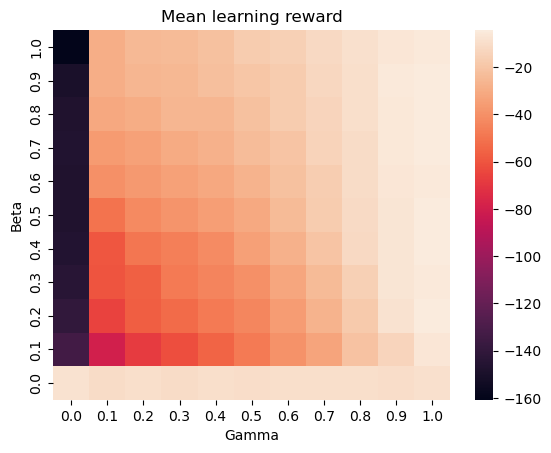

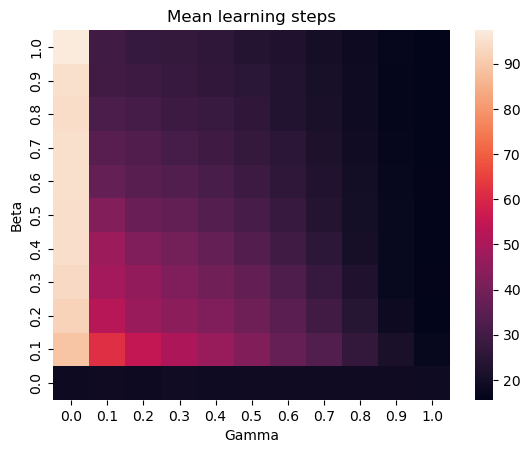

In [3]:
env = gym.make('Taxi-v3')
Q = np.random.rand(env.observation_space.n, env.action_space.n)
gammas = np.arange(0, 1.1, 0.1)
betas = np.arange(1, -0.1, -0.1)
map_steps = []
map_rewards = []

for beta in betas:
    step_row = []
    reward_row = []
    for gamma in gammas:
        _, rewards, steps = qlearning(100, gamma, beta, Q, 0.2, env.reset, env.step, 1000)
        step_row.append(np.mean(steps))
        reward_row.append(np.mean(rewards))
    map_steps.append(step_row)
    map_rewards.append(reward_row)

sns.heatmap(map_rewards, xticklabels=np.round(gammas, 1), yticklabels=np.round(betas, 2))
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.title('Mean learning reward')
plt.show()
sns.heatmap(map_steps, xticklabels=np.round(gammas, 1), yticklabels=np.round(betas, 2))
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.title('Mean learning steps')
plt.show();




Następnie zbadany został wpływ parametru eps na wydajność algorytmu. Wykres przedstawia średnią ilośc uzyskanych nagród podczas jednej rozgrywki oraz średnią ilość kroków potrzebnych do zakończenia rozgrywki. Jak można zauważyć wartosci te pogarszały się wraz ze wzrostem parametru eps, ponieważ oznacza to wzrost prawdopodobieństwa na losowy ruch. Najlepiej wypadł algorytm z eps=0.1. Jest to odpowiednia ilość, ponieważ umożliwia eksploracji przez większość rozgrywki wykonywać najlepszy ruch, natomiast daje też szanse innym ruchom. 

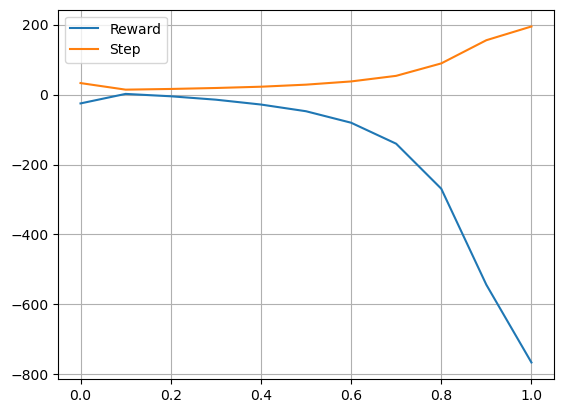

In [4]:
env = gym.make('Taxi-v3')
Q = np.random.rand(env.observation_space.n, env.action_space.n)

epsilons = np.arange(0, 1.1, 0.1)
step = []
reward = []

for eps in epsilons:
    _, rewards, steps = qlearning(200, 1, 0.5, Q, eps, env.reset, env.step, 1000)
    step.append(np.mean(steps))
    reward.append(np.mean(rewards))

plt.plot(epsilons, reward, label='Reward')
plt.plot(epsilons, step, label='Step')
plt.legend()
plt.grid(True)
plt.show()

Poniższy przebieg przedstawia to jak zmieniają się wartości nagród i kroków zebranych podczas jednego nauczania. Można zobaczyć duże rozbieżności w początkowej fazie nauczania, natomiast od około epizodu 300 wartości te się w miarę ustabilizowały. Przedstawia to, że parametry które zostały dobrane do nauczania zaimplementowanym algorytmem są poprawne. 

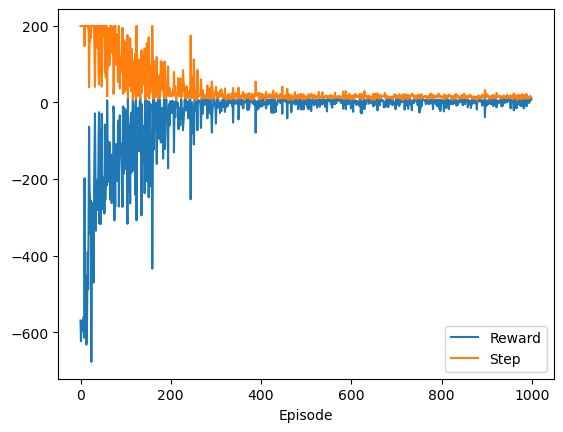

In [5]:
env = gym.make('Taxi-v3')
Q = np.random.rand(env.observation_space.n, env.action_space.n)

_, rewards, steps = qlearning(200, 1, 0.5, Q, 0.1, env.reset, env.step, 1000)

plt.plot(rewards, label='Reward')
plt.plot(steps, label='Step')
plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.show()

Została przeprowadzona próba dla 1000 gier. Limit kroków na gre został ustawiony na 25. Jak można zauważyć algorytm dobrze sobie poradził, dając wynik win ratio 97.7%.

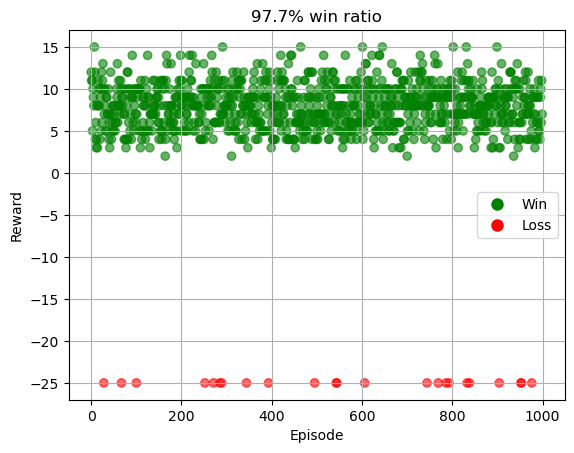

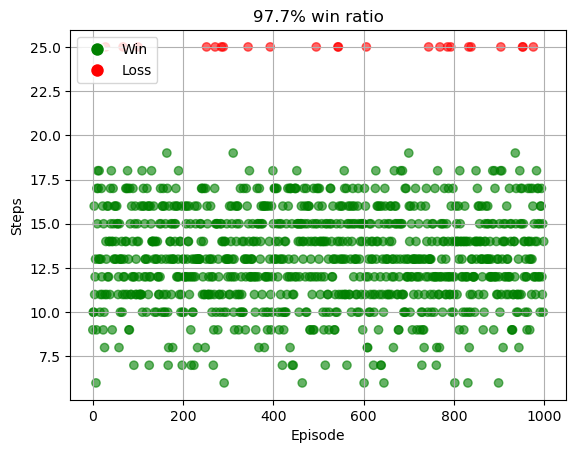

In [6]:
env = gym.make('Taxi-v3')
Q = np.random.rand(env.observation_space.n, env.action_space.n)

Q, _, _ = qlearning(1000, 1, 0.5, Q, 0.1, env.reset, env.step, 1000)

num_steps = 25
wins = []
rewards = []
steps = []

for _ in range(1000):
    state = env.reset()[0]
    final_reward = 0
    for step in range(num_steps):
        action = np.argmax(Q[state])
        state, reward, done, _, _ = env.step(action)
        final_reward += reward
        if done:
            wins.append(1)
            steps.append(step+1)
            rewards.append(final_reward)
            break
    if not done:
        wins.append(0)
        steps.append(step+1)
        rewards.append(final_reward)

episodes = np.arange(len(rewards))
colors = ['green' if win else 'red' for win in wins]

plt.scatter(episodes, rewards, c=colors, alpha=0.6)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'{np.round(np.sum(wins)/len(wins)*100, 2)}% win ratio')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Win'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Loss')]
plt.legend(handles=handles)
plt.grid(True)
plt.show()


plt.scatter(episodes, steps, c=colors, alpha=0.6)

plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title(f'{np.round(np.sum(wins)/len(wins)*100, 2)}% win ratio')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Win'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Loss')]
plt.legend(handles=handles)
plt.grid(True)
plt.show()

Poniżej przedstawiona jest symulacja rozgrywki agenta nauczonego algorytmem Q-learning.

In [7]:
env = gym.make('Taxi-v3')
Q = np.random.rand(env.observation_space.n, env.action_space.n)

Q, _, _ = qlearning(200, 1, 0.5, Q, 0.1, env.reset, env.step, 10000)

env = gym.make('Taxi-v3', render_mode='human')

state = env.reset()[0]

num_steps = 25

for step in range(num_steps):
    env.render()
    
    action = np.argmax(Q[state])
    
    state, reward, done, _, _ = env.step(action)
    
    if done:
        break

env.close()